In [ ]:
#-----------------------------------------------------------------------------------------------------
# Cell-1:
# ---- Mount Google Drive ----
from google.colab import drive
drive.mount('/content/drive')

import os
import numpy as np
import pandas as pd
from typing import List, Dict

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

import torch
from torch.utils.data import Dataset

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
    set_seed
)

# ---- Configuration ----
set_seed(42)

DATASET_DIR = "/content/drive/MyDrive/Malware_Dataset/"
TEXT_COLUMN = "text"
LABEL_COLUMN = "label"

MODEL_NAME = "distilbert-base-uncased"
OUTPUT_DIR = "/content/drive/MyDrive/Malware_Dataset/distilbert_phishing_output"

MAX_LENGTH = 256
TEST_SIZE = 0.2
BATCH_SIZE = 16
EPOCHS = 2
LEARNING_RATE = 2e-5

# ------------------Intent Categorization Config ------------------
INTENT_LABELS = ["link", "attachment", "service", "other"]
INTENT2ID = {k: i for i, k in enumerate(INTENT_LABELS)}
ID2INTENT = {i: k for k, i in INTENT2ID.items()}

INTENT_OUTPUT_DIR = "/content/drive/MyDrive/Malware_Dataset/distilbert_intent_output"
#-----------------------------------------------------------------------------------------------------


Mounted at /content/drive


In [ ]:
#----------------------------------------------------------------------------------------------------
# Cell-2: Load + Merge CSVs + Binary + Intent Labels
#----------------------------------------------------------------------------------------------------
import glob
import io
import re

DATASET_DIR = "/content/drive/MyDrive/Malware_Dataset/"
csv_files = sorted(glob.glob(os.path.join(DATASET_DIR, "*.csv")))

if len(csv_files) == 0:
    raise FileNotFoundError(f"No CSV files found in: {DATASET_DIR}")

all_dfs = []
skipped_files = []

def normalize_label(x):
    if pd.isna(x):
        return np.nan
    if isinstance(x, str):
        x = x.lower().strip()
        if x in ["phish", "phishing", "spam", "scam", "malicious", "1"]:
            return 1
        if x in ["legit", "legitimate", "ham", "benign", "0"]:
            return 0
        return np.nan
    try:
        return int(x)
    except Exception:
        return np.nan

def pick_col(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    return None

def robust_read_csv(path):
    try:
        return pd.read_csv(path)
    except Exception:
        raw = open(path, "rb").read()
        raw = raw.replace(b"\x00", b"")
        text = raw.decode("utf-8", errors="replace")
        return pd.read_csv(
            io.StringIO(text),
            engine="python",
            on_bad_lines="skip"
        )

# ------------------ Intent heuristics ------------------
URL_RE = re.compile(r"(https?://|www\.)\S+|\b[a-z0-9.-]+\.(com|net|org|ru|cn|io|co)\b", re.I)
ATTACH_RE = re.compile(r"\b(attach|attachment|invoice|receipt|pdf|docx|xlsx|zip|rar|7z|download)\b", re.I)
SERVICE_RE = re.compile(r"\b(call|phone|dial|sms|text|whatsapp|telegram|support|customer service)\b", re.I)

def infer_intent(text: str) -> str:
    t = (text or "").lower()
    if URL_RE.search(t) or "click here" in t:
        return "link"
    if ATTACH_RE.search(t):
        return "attachment"
    if SERVICE_RE.search(t) or re.search(r"\b\d{3}[-.\s]?\d{3}[-.\s]?\d{4}\b", t):
        return "service"
    return "other"

# ------------------ Load & merge datasets ------------------
for f in csv_files:
    try:
        temp = robust_read_csv(f)
        temp.columns = temp.columns.astype(str).str.strip()

        if "Label" in temp.columns and "label" not in temp.columns:
            temp.rename(columns={"Label": "label"}, inplace=True)

        if "label" not in temp.columns:
            skipped_files.append((os.path.basename(f), "Missing label column"))
            continue

        text_col = pick_col(temp, ["text", "email_text", "EmailText", "content", "message"])
        if text_col is not None:
            temp["text"] = temp[text_col].fillna("").astype(str)
        else:
            subj_col = pick_col(temp, ["subject", "Subject"])
            body_col = pick_col(temp, ["body", "Body"])
            urls_col = pick_col(temp, ["urls", "URLs", "url", "URL"])

            temp["text"] = (
                "Subject: " + (temp[subj_col].fillna("").astype(str) if subj_col else "") + "\n"
                "Body: " + (temp[body_col].fillna("").astype(str) if body_col else "") + "\n"
                "URLs: " + (temp[urls_col].fillna("").astype(str) if urls_col else "")
            )

        temp["label"] = temp["label"].apply(normalize_label)
        temp = temp.dropna(subset=["label"])
        temp["label"] = temp["label"].astype(int)

        all_dfs.append(temp[["text", "label"]])

    except Exception as e:
        skipped_files.append((os.path.basename(f), str(e)))

if len(all_dfs) == 0:
    raise ValueError("No usable datasets were loaded.")

df = pd.concat(all_dfs, ignore_index=True)
df = df.drop_duplicates(subset=["text", "label"]).reset_index(drop=True)

# ------------------ Intent labeling (phishing only) ------------------
df["intent"] = "other"
phish_mask = df["label"] == 1
df.loc[phish_mask, "intent"] = df.loc[phish_mask, "text"].apply(infer_intent)
df["intent_id"] = df["intent"].map(INTENT2ID)


print(f"Loaded CSV files: {len(csv_files)}")
print(f"Usable datasets merged: {len(all_dfs)}")

print(f"\nDataset Shape: {df[['text', 'label']].shape}")

label_counts = df["label"].value_counts()

print("\nLabel:")
print("Phishing Emails = 1")
print("Legitimate Emails = 0")
print(f"Number of Phishing Emails: {label_counts.get(1, 0)}")
print(f"Number of Legitimate Emails: {label_counts.get(0, 0)}")

# ------------------ Train / Validation Splits ------------------
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df["text"].astype(str).tolist(),
    df["label"].tolist(),
    test_size=TEST_SIZE,
    random_state=42,
    stratify=df["label"]
)

print(f"\nTrain Size: {len(train_texts)} | Validation Size: {len(val_texts)}")

# ------------------ Intent dataset split (phishing only) ------------------
intent_df = df[df["label"] == 1].copy()

intent_train_texts, intent_val_texts, intent_train_labels, intent_val_labels = train_test_split(
    intent_df["text"].astype(str).tolist(),
    intent_df["intent_id"].tolist(),
    test_size=TEST_SIZE,
    random_state=42,
    stratify=intent_df["intent_id"]
)

print("\nIntent Distribution (Phishing Emails Only):")
print(intent_df["intent"].value_counts())

print(f"\nIntent Train Size: {len(intent_train_texts)} | Intent Validation Size: {len(intent_val_texts)}")
#----------------------------------------------------------------------------------------------------


Loaded CSV files: 13
Usable datasets merged: 13

Dataset Shape: (219324, 2)

Label:
Phishing Emails = 1
Legitimate Emails = 0
Number of Phishing Emails: 105241
Number of Legitimate Emails: 114083

Train Size: 175459 | Validation Size: 43865

Intent Distribution (Phishing Emails Only):
intent
link          57361
other         37917
service        7616
attachment     2347
Name: count, dtype: int64

Intent Train Size: 84192 | Intent Validation Size: 21049


In [ ]:
#----------------------------------------------------------------------------------------------------
# Cell-3: Tokenizer + Dataset + Train (Binary + Intent)
#----------------------------------------------------------------------------------------------------

# ---- Tokenizer ----
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

class EmailDataset(Dataset):
    def __init__(self, texts: List[str], labels: List[int]):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx) -> Dict[str, torch.Tensor]:
        encoding = tokenizer(
            self.texts[idx],
            truncation=True,
            max_length=MAX_LENGTH,
            return_tensors="pt"
        )
        item = {k: v.squeeze(0) for k, v in encoding.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# ------------------ Print Epoch Table + Batch Loss Table ------------------
def _avg_train_loss_by_epoch(log_history):
    """
    Returns dict: {epoch_int: avg_training_loss} using all training loss logs in that epoch.
    Buckets epochs robustly so it never ends up as N/A due to float mismatch.
    """
    bucket = {}  # epoch_int -> list of losses
    for log in log_history:
        if "loss" in log and "epoch" in log and "eval_loss" not in log:
            ep_int = int(round(float(log["epoch"])))
            bucket.setdefault(ep_int, []).append(float(log["loss"]))

    avg = {}
    for ep_int, losses in bucket.items():
        if len(losses) > 0:
            avg[ep_int] = sum(losses) / len(losses)
    return avg

def _build_epoch_rows(log_history):
    """
    Builds epoch rows:
    Epoch | Training Loss (avg) | Validation Loss | Accuracy | Precision | Recall | F1
    """
    avg_loss = _avg_train_loss_by_epoch(log_history)

    rows = []
    for log in log_history:
        if "eval_loss" in log and "epoch" in log:
            ep_int = int(round(float(log["epoch"])))
            rows.append({
                "epoch": ep_int,
                "train_loss": avg_loss.get(ep_int, None),
                "eval_loss": float(log.get("eval_loss", 0.0)),
                "accuracy": float(log.get("eval_accuracy", 0.0)),
                "precision": float(log.get("eval_precision", 0.0)),
                "recall": float(log.get("eval_recall", 0.0)),
                "f1": float(log.get("eval_f1", 0.0)),
            })

    # remove duplicates by epoch
    dedup = {}
    for r in rows:
        dedup[r["epoch"]] = r
    rows = [dedup[k] for k in sorted(dedup.keys())]
    return rows

def _print_epoch_table(title, rows):
    print(f"\n{title}")
    header = f"{'Epoch':<6}{'Training Loss':<16}{'Validation Loss':<18}{'Accuracy':<12}{'Precision':<12}{'Recall':<12}{'F1':<12}"
    print(header)
    for r in rows:
        train_loss = r["train_loss"]
        train_loss_str = f"{train_loss:.6f}" if train_loss is not None else "N/A"
        print(
            f"{r['epoch']:<6}"
            f"{train_loss_str:<16}"
            f"{r['eval_loss']:<18.6f}"
            f"{r['accuracy']:<12.6f}"
            f"{r['precision']:<12.6f}"
            f"{r['recall']:<12.6f}"
            f"{r['f1']:<12.6f}"
        )

def _print_batch_loss_table(trainer_obj, title):
    print(f"\n{title}")
    print(f"{'Batch':<6} | {'Training Loss':<13} | {'Training Loss Percentage'}")
    printed_any = False
    for log in trainer_obj.state.log_history:
        if "loss" in log and "step" in log and "eval_loss" not in log:
            batch = int(log["step"])
            loss = float(log["loss"])
            loss_pct = loss * 100
            print(f"{batch:<6} | {loss:<13.6f} | {loss_pct:.4f}%")
            printed_any = True
    if not printed_any:
        print("No batch-level loss logs recorded. Try lowering logging_steps (ex: 50).")

# ------------------ Binary: Datasets ------------------
train_ds = EmailDataset(train_texts, train_labels)
val_ds = EmailDataset(val_texts, val_labels)

# ------------------ Binary: Model ------------------
binary_model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2
)

# ------------------ Binary: Metrics ------------------
def compute_binary_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)

    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average="binary", zero_division=0
    )
    acc = accuracy_score(labels, preds)

    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

# ------------------ Binary: TrainingArguments ------------------
binary_base_args = dict(
    output_dir=OUTPUT_DIR,
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=EPOCHS,
    weight_decay=0.01,

    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,

    warmup_ratio=0.1,
    logging_steps=200,
    report_to="none",
    fp16=torch.cuda.is_available()
)

try:
    binary_args = TrainingArguments(**binary_base_args, eval_strategy="epoch")
except TypeError:
    binary_args = TrainingArguments(**binary_base_args, evaluation_strategy="epoch")

binary_trainer = Trainer(
    model=binary_model,
    args=binary_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_binary_metrics
)

# ------------------ Train Binary ------------------
binary_trainer.train()

# ------------------ Print Binary Tables ------------------
binary_rows = _build_epoch_rows(binary_trainer.state.log_history)
_print_epoch_table("Binary Model (Phishing vs Legit) — Epoch Results:", binary_rows)
_print_batch_loss_table(binary_trainer, "Binary Model — Batch Training Loss Table:")

# ===================== INTENT MODEL TRAINING =====================

# ------------------ Intent: Datasets (phishing only) ------------------
intent_train_ds = EmailDataset(intent_train_texts, intent_train_labels)
intent_val_ds = EmailDataset(intent_val_texts, intent_val_labels)

# ------------------ Intent: Model ------------------
intent_model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(INTENT_LABELS),
    id2label=ID2INTENT,
    label2id=INTENT2ID
)

# ------------------ Intent: Metrics (weighted for multi-class) ------------------
def compute_intent_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)

    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average="weighted", zero_division=0
    )
    acc = accuracy_score(labels, preds)

    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

# ------------------ Intent: TrainingArguments ------------------
intent_base_args = dict(
    output_dir=INTENT_OUTPUT_DIR,
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=EPOCHS,
    weight_decay=0.01,

    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,

    warmup_ratio=0.1,
    logging_steps=200,
    report_to="none",
    fp16=torch.cuda.is_available()
)

try:
    intent_args = TrainingArguments(**intent_base_args, eval_strategy="epoch")
except TypeError:
    intent_args = TrainingArguments(**intent_base_args, evaluation_strategy="epoch")

intent_trainer = Trainer(
    model=intent_model,
    args=intent_args,
    train_dataset=intent_train_ds,
    eval_dataset=intent_val_ds,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_intent_metrics
)

# ------------------ Train Intent ------------------
intent_trainer.train()

# ------------------ Print Intent Tables ------------------
intent_rows = _build_epoch_rows(intent_trainer.state.log_history)
_print_epoch_table("Intent Model (Link/Attachment/Service/Other) — Epoch Results:", intent_rows)
_print_batch_loss_table(intent_trainer, "Intent Model — Batch Training Loss Table:")

#----------------------------------------------------------------------------------------------------


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1722740210.py:154: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  binary_trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.046800,0.029607,0.992272,0.988673,0.995296,0.991974
2,0.012600,0.025249,0.994346,0.995050,0.993158,0.994103



Binary Model (Phishing vs Legit) — Epoch Results:
Epoch Training Loss   Validation Loss   Accuracy    Precision   Recall      F1          
1     0.028236        0.029607          0.992272    0.988673    0.995296    0.991974    
2     0.013511        0.025249          0.994346    0.995050    0.993158    0.994103    

Binary Model — Batch Training Loss Table:
Batch  | Training Loss | Training Loss Percentage
200    | 0.670600      | 67.0600%
400    | 0.347700      | 34.7700%
600    | 0.169500      | 16.9500%
800    | 0.154300      | 15.4300%
1000   | 0.111800      | 11.1800%
1200   | 0.124900      | 12.4900%
1400   | 0.109500      | 10.9500%
1600   | 0.091800      | 9.1800%
1800   | 0.115400      | 11.5400%
2000   | 0.111300      | 11.1300%
2200   | 0.091400      | 9.1400%
2400   | 0.084100      | 8.4100%
2600   | 0.078700      | 7.8700%
2800   | 0.075100      | 7.5100%
3000   | 0.063300      | 6.3300%
3200   | 0.086700      | 8.6700%
3400   | 0.055300      | 5.5300%
3600   | 0.068800  

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1722740210.py:223: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  intent_trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.183700,0.198419,0.940805,0.939666,0.940805,0.939236
2,0.124700,0.175253,0.947123,0.946491,0.947123,0.945901



Intent Model (Link/Attachment/Service/Other) — Epoch Results:
Epoch Training Loss   Validation Loss   Accuracy    Precision   Recall      F1          
1     0.174369        0.198419          0.940805    0.939666    0.940805    0.939236    
2     0.140854        0.175253          0.947123    0.946491    0.947123    0.945901    

Intent Model — Batch Training Loss Table:
Batch  | Training Loss | Training Loss Percentage
200    | 1.160400      | 116.0400%
400    | 0.645500      | 64.5500%
600    | 0.456100      | 45.6100%
800    | 0.410300      | 41.0300%
1000   | 0.423600      | 42.3600%
1200   | 0.362100      | 36.2100%
1400   | 0.286600      | 28.6600%
1600   | 0.291900      | 29.1900%
1800   | 0.236100      | 23.6100%
2000   | 0.244900      | 24.4900%
2200   | 0.253700      | 25.3700%
2400   | 0.235300      | 23.5300%
2600   | 0.240900      | 24.0900%
2800   | 0.244400      | 24.4400%
3000   | 0.211600      | 21.1600%
3200   | 0.210800      | 21.0800%
3400   | 0.186800      | 18.6800

In [ ]:
#----------------------------------------------------------------------------------------------------
# Cell-4:Evaluate (Binary + Intent) + Confusion Matrices + Save Models ----
#----------------------------------------------------------------------------------------------------

from sklearn.metrics import confusion_matrix, classification_report

# ===================== BINARY EVALUATION =====================
results = binary_trainer.evaluate()

print("\nEvaluation Results (Binary - Table):")
print(f"{'Metric':<30}{'Value'}")
print("-" * 45)
for key, value in results.items():
    print(f"{key:<30}{value}")

# ---- Binary Confusion Matrix ----
binary_preds = binary_trainer.predict(val_ds)
binary_y_pred = np.argmax(binary_preds.predictions, axis=1)
binary_cm = confusion_matrix(val_labels, binary_y_pred)

print("\nBinary Confusion Matrix:")
print(binary_cm)

print("\nBinary Confusion Matrix (Label):")
print(f"{'Category':<35}{'Count'}")
print("-" * 55)

if binary_cm.shape == (2, 2):
    tn, fp, fn, tp = binary_cm.ravel()
    print(f"{'True Negatives (Legit Emails):':<35}{tn}")
    print(f"{'False Positives:':<35}{fp}")
    print(f"{'False Negatives:':<35}{fn}")
    print(f"{'True Positives (Phishing Emails):':<35}{tp}")
elif binary_cm.shape == (1, 1):
    only_count = int(binary_cm[0, 0])
    unique_labels = sorted(set(val_labels))
    if len(unique_labels) == 1:
        only_label = unique_labels[0]
        if only_label == 0:
            print(f"{'All validation emails were Legit (0):':<35}{only_count}")
        else:
            print(f"{'All validation emails were Phishing (1):':<35}{only_count}")
else:
    print(f"{'Unexpected confusion matrix shape:':<35}{str(binary_cm.shape)}")

# ===================== INTENT EVALUATION =====================
intent_results = intent_trainer.evaluate()

print("\nEvaluation Results (Intent - Table):")
print(f"{'Metric':<30}{'Value'}")
print("-" * 45)
for key, value in intent_results.items():
    print(f"{key:<30}{value}")

# ---- Intent Confusion Matrix ----
intent_preds = intent_trainer.predict(intent_val_ds)
intent_y_pred = np.argmax(intent_preds.predictions, axis=1)
intent_cm = confusion_matrix(intent_val_labels, intent_y_pred, labels=list(range(len(INTENT_LABELS))))

print("\nIntent Confusion Matrix (Raw):")
print(intent_cm)

print("\nIntent Labels:")
for i in range(len(INTENT_LABELS)):
    print(f"{i}: {ID2INTENT[i]}")

print("\nIntent Confusion Matrix (Readable):")
header = " " * 14 + " ".join([f"{ID2INTENT[i][:10]:>10}" for i in range(len(INTENT_LABELS))])
print(header)
for i in range(len(INTENT_LABELS)):
    row_name = f"{ID2INTENT[i]:<12}"
    row_vals = " ".join([f"{intent_cm[i, j]:>10}" for j in range(len(INTENT_LABELS))])
    print(row_name + "  " + row_vals)

# ---- Per-class report for intent ----
print("\nIntent Classification Report:")
print(classification_report(
    intent_val_labels,
    intent_y_pred,
    target_names=[ID2INTENT[i] for i in range(len(INTENT_LABELS))],
    zero_division=0
))

# ===================== SAVE MODELS =====================

# ---- Save Binary Model ----
BINARY_FINAL_DIR = os.path.join(OUTPUT_DIR, "distilbert_phishing_final")
os.makedirs(BINARY_FINAL_DIR, exist_ok=True)

binary_trainer.save_model(BINARY_FINAL_DIR)
tokenizer.save_pretrained(BINARY_FINAL_DIR)

print("\nBinary model saved to:", BINARY_FINAL_DIR)

# ---- Save Intent Model ----
INTENT_FINAL_DIR = os.path.join(INTENT_OUTPUT_DIR, "distilbert_intent_final")
os.makedirs(INTENT_FINAL_DIR, exist_ok=True)

intent_trainer.save_model(INTENT_FINAL_DIR)
tokenizer.save_pretrained(INTENT_FINAL_DIR)

print("Intent model saved to:", INTENT_FINAL_DIR)

#----------------------------------------------------------------------------------------------------



Evaluation Results (Binary - Table):
Metric                        Value
---------------------------------------------
eval_loss                     0.02524937503039837
eval_accuracy                 0.9943462897526502
eval_precision                0.995049504950495
eval_recall                   0.9931584948688712
eval_f1                       0.9941031006277344
eval_runtime                  116.9605
eval_samples_per_second       375.041
eval_steps_per_second         23.444
epoch                         2.0

Binary Confusion Matrix:
[[22713   104]
 [  144 20904]]

Binary Confusion Matrix (Label):
Category                           Count
-------------------------------------------------------
True Negatives (Legit Emails):     22713
False Positives:                   104
False Negatives:                   144
True Positives (Phishing Emails):  20904



Evaluation Results (Intent - Table):
Metric                        Value
---------------------------------------------
eval_loss                     0.175252765417099
eval_accuracy                 0.94712337878284
eval_precision                0.9464910278174864
eval_recall                   0.94712337878284
eval_f1                       0.9459010056390718
eval_runtime                  62.5189
eval_samples_per_second       336.682
eval_steps_per_second         21.05
epoch                         2.0

Intent Confusion Matrix (Raw):
[[11221    12    39   201]
 [   81   309    31    48]
 [  153     7  1195   168]
 [  322    12    39  7211]]

Intent Labels:
0: link
1: attachment
2: service
3: other

Intent Confusion Matrix (Readable):
                    link attachment    service      other
link               11221         12         39        201
attachment            81        309         31         48
service              153          7       1195        168
other                322  

In [ ]:
#----------------------------------------------------------------------------------------------------
# Cell-5: Rule-Based Reasoning + Ready for Cell-6
#----------------------------------------------------------------------------------------------------

import re

# --- Reasoning cue regex patterns ---
URL_RE_REASON = re.compile(r"(https?://|www\.)\S+|\b[a-z0-9.-]+\.(com|net|org|ru|cn|io|co)\b", re.I)
ATTACH_RE_REASON = re.compile(r"\b(attach|attachment|pdf|docx|xlsx|zip|rar|7z|download)\b", re.I)
URGENCY_RE_REASON = re.compile(r"\b(urgent|immediately|within\s*\d+\s*hours|within 24 hours|account suspended|action required|final notice)\b", re.I)
CRED_RE_REASON = re.compile(r"\b(verify|confirm|reset|login|password|sign in|update account)\b", re.I)
SERVICE_RE_REASON = re.compile(r"\b(call|phone|dial|sms|text|whatsapp|telegram|support|customer service)\b", re.I)
PHONE_RE_REASON = re.compile(r"\b\d{3}[-.\s]?\d{3}[-.\s]?\d{4}\b")

def extract_reasoning_cues(text: str):
    """
    Returns a list of human-readable cues found in the email text.
    Deterministic, fast, and explainable (no LLM needed).
    """
    cues = []
    t = (text or "").lower()

    # Link cues
    if URL_RE_REASON.search(t) or "click here" in t:
        cues.append("contains a suspicious link")

    # Attachment cues
    if ATTACH_RE_REASON.search(t):
        cues.append("attempts to get the user to open or download an attachment")

    # Urgency / pressure cues
    if URGENCY_RE_REASON.search(t):
        cues.append("uses urgency or pressure tactics")

    # Credential/account manipulation cues
    if CRED_RE_REASON.search(t):
        cues.append("requests sensitive account-related actions")

    # Service redirection cues
    if SERVICE_RE_REASON.search(t) or PHONE_RE_REASON.search(t):
        cues.append("redirects the user to an external service (phone/SMS/support)")

    return cues


def generate_reasoning(text: str, intent: str) -> str:
    """
    Produces a 1–2 sentence explanation aligned with the paper's "justification" idea,
    but implemented deterministically with extracted cues.
    """
    cues = extract_reasoning_cues(text)

    if not cues:
        return (
            f"The email was classified as phishing via {intent} based on its overall language and structure, "
            f"which match common phishing patterns."
        )

    cues_text = "; ".join(cues)
    return (
        f"The email was classified as phishing via {intent} because it {cues_text}, "
        f"which is consistent with common phishing tactics."
    )

print("Cell-5 loaded: Rule-based reasoning is ready.")
#----------------------------------------------------------------------------------------------------


✅ Cell-5 loaded: Rule-based reasoning is ready.


✅ Cell-6 loaded: Tables + downloadable visuals enabled.


,Field,Value
0,Detection,Phishing
1,Intent,link
2,Indicator #1,contains a suspicious link
3,Indicator #2,uses urgency or pressure tactics
4,Indicator #3,requests sensitive account-related actions
5,Explanation,The email was classified as phishing via link ...


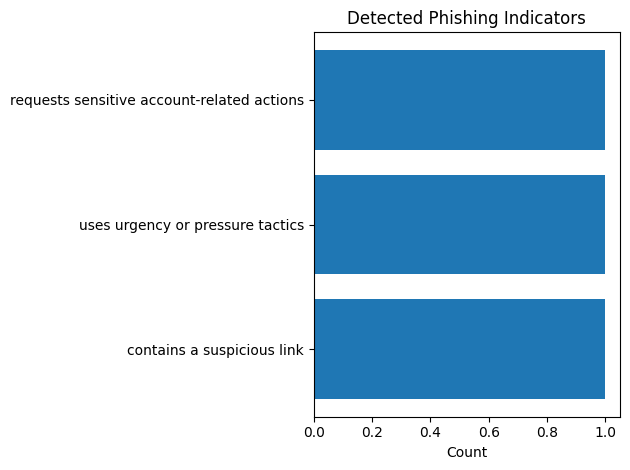

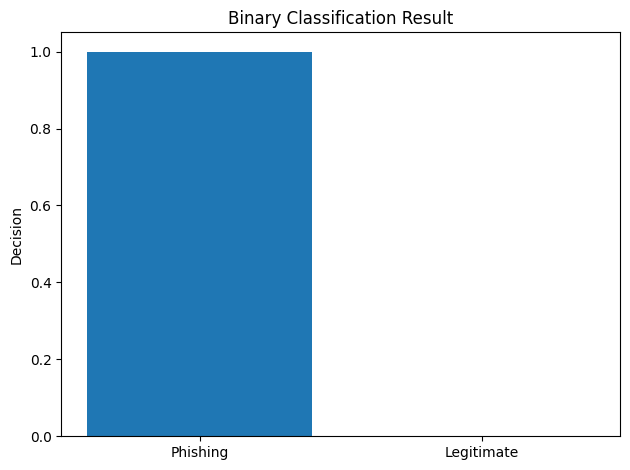


📁 Visuals saved to:
/content/explanation_visuals/demo_email_indicators.png
/content/explanation_visuals/demo_email_decision.png


from matplotlib import pyplot as plt
import seaborn as sns
_df_12.groupby('Field').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_13.groupby('Value').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['Value'].value_counts()
    for x_label, grp in _df_14.groupby('Field')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Field')
_ = plt.ylabel('Value')

In [ ]:
#----------------------------------------------------------------------------------------------------
# Cell-6: Unified Inference + Explanation Table + AUTO-SAVED VISUAL CHARTS
#----------------------------------------------------------------------------------------------------

import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import os

VISUAL_OUTPUT_DIR = "/content/explanation_visuals"
os.makedirs(VISUAL_OUTPUT_DIR, exist_ok=True)

def predict_email_with_reasoning(text: str):
    device = next(binary_model.parameters()).device
    binary_model.eval()
    intent_model.eval()

    enc = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        max_length=MAX_LENGTH
    )
    enc = {k: v.to(device) for k, v in enc.items()}

    # -------- Stage 1: Binary --------
    with torch.no_grad():
        phish_logits = binary_model(**enc).logits
    is_phish = int(torch.argmax(phish_logits, dim=1).item())

    if is_phish == 0:
        return {
            "phishing": 0,
            "intent": "legit",
            "cues": [],
            "reasoning": "No phishing indicators detected."
        }

    # -------- Stage 2: Intent --------
    with torch.no_grad():
        intent_logits = intent_model(**enc).logits
    intent_id = int(torch.argmax(intent_logits, dim=1).item())
    intent = ID2INTENT[intent_id]

    # -------- Stage 3: Reasoning --------
    cues = extract_reasoning_cues(text)
    reasoning = generate_reasoning(text, intent)

    return {
        "phishing": 1,
        "intent": intent,
        "cues": cues,
        "reasoning": reasoning
    }


def render_and_save_explanation(result: dict, prefix="email"):
    rows = [
        ("Detection", "Phishing" if result["phishing"] else "Legitimate"),
        ("Intent", result["intent"])
    ]

    for i, cue in enumerate(result["cues"], 1):
        rows.append((f"Indicator #{i}", cue))

    rows.append(("Explanation", result["reasoning"]))

    df = pd.DataFrame(rows, columns=["Field", "Value"])

    # ---- Display table ----
    display(df)

    # ---- Chart 1: Indicator Frequency ----
    if result["cues"]:
        cue_counts = Counter(result["cues"])
        plt.figure()
        plt.barh(list(cue_counts.keys()), list(cue_counts.values()))
        plt.title("Detected Phishing Indicators")
        plt.xlabel("Count")
        plt.tight_layout()

        indicator_path = f"{VISUAL_OUTPUT_DIR}/{prefix}_indicators.png"
        plt.savefig(indicator_path, dpi=300)
        plt.show()

    # ---- Chart 2: Decision Summary ----
    plt.figure()
    plt.bar(["Phishing", "Legitimate"],
            [1 if result["phishing"] else 0, 0 if result["phishing"] else 1])
    plt.title("Binary Classification Result")
    plt.ylabel("Decision")
    plt.tight_layout()

    decision_path = f"{VISUAL_OUTPUT_DIR}/{prefix}_decision.png"
    plt.savefig(decision_path, dpi=300)
    plt.show()

    print("\n📁 Visuals saved to:")
    print(indicator_path if result["cues"] else "")
    print(decision_path)



print("Cell-6 loaded: Tables + downloadable visuals enabled.")

demo_email = """Subject: Account Alert
Body: Your account will be suspended within 24 hours. Click here to verify:
https://secure-login.example.com"""

demo_result = predict_email_with_reasoning(demo_email)
render_and_save_explanation(demo_result, prefix="demo_email")

#----------------------------------------------------------------------------------------------------
